In [2]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [4]:
# load the dataset
dataframe = pandas.read_excel('Golbal_combined2.xlsx', usecols=[1])
dataset = dataframe.values
dataset = dataset.astype('float32')

In [5]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [6]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

335 165


In [7]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [8]:
# reshape into X=t and Y=t+1
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [9]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [10]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(2, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
329/329 - 9s - loss: 0.0060 - 9s/epoch - 29ms/step
Epoch 2/100
329/329 - 2s - loss: 0.0037 - 2s/epoch - 6ms/step
Epoch 3/100
329/329 - 2s - loss: 0.0033 - 2s/epoch - 6ms/step
Epoch 4/100
329/329 - 2s - loss: 0.0033 - 2s/epoch - 6ms/step
Epoch 5/100
329/329 - 2s - loss: 0.0031 - 2s/epoch - 5ms/step
Epoch 6/100
329/329 - 2s - loss: 0.0030 - 2s/epoch - 6ms/step
Epoch 7/100
329/329 - 2s - loss: 0.0029 - 2s/epoch - 6ms/step
Epoch 8/100
329/329 - 2s - loss: 0.0028 - 2s/epoch - 6ms/step
Epoch 9/100
329/329 - 2s - loss: 0.0027 - 2s/epoch - 6ms/step
Epoch 10/100
329/329 - 2s - loss: 0.0027 - 2s/epoch - 6ms/step
Epoch 11/100
329/329 - 3s - loss: 0.0027 - 3s/epoch - 9ms/step
Epoch 12/100
329/329 - 2s - loss: 0.0025 - 2s/epoch - 6ms/step
Epoch 13/100
329/329 - 2s - loss: 0.0025 - 2s/epoch - 6ms/step
Epoch 14/100
329/329 - 2s - loss: 0.0025 - 2s/epoch - 6ms/step
Epoch 15/100
329/329 - 2s - loss: 0.0024 - 2s/epoch - 7ms/step
Epoch 16/100
329/329 - 2s - loss: 0.0025 - 2s/epoch - 6ms/step


In [11]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 64086.16 RMSE
Test Score: 79304.81 RMSE


In [19]:
from sklearn.metrics import explained_variance_score, r2_score, mean_squared_error, mean_absolute_percentage_error,mean_absolute_error
print(' r2_score',r2_score(testY[0], testPredict[:,0]))
print('Mean Square Error',mean_squared_error(testY[0], testPredict[:,0]))
print('Mean Absolute Error',mean_absolute_error(testY[0], testPredict[:,0]))
print('Mean Absolute percentage Error',mean_absolute_percentage_error(testY[0], testPredict[:,0]))

 r2_score 0.7667368481124832
Mean Square Error 6289252626.674711
Mean Absolute Error 58100.973738778805
Mean Absolute percentage Error 0.11034868641945525


In [12]:
mean_squared_error(trainY[0], trainPredict[:,0])

4107036081.9784436

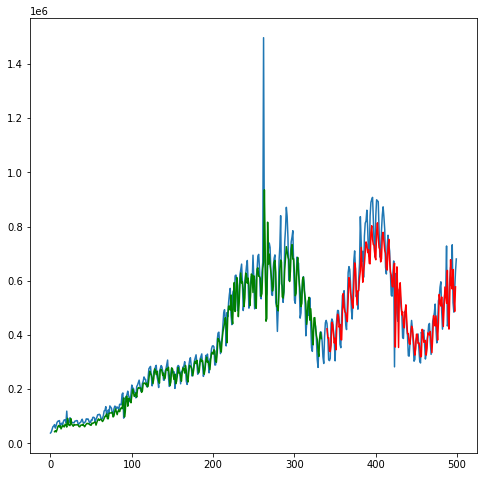

Text(0, 0.5, 'Confirmed cases daily')

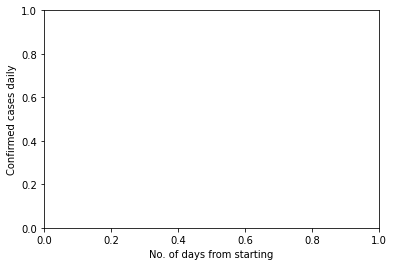

In [17]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(8,8))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot,'g')
plt.plot(testPredictPlot,'r')
plt.show()
plt.xlabel('No. of days from starting')
plt.ylabel('Confirmed cases daily')
